In [1]:
from pyspark.sql import  SQLContext 
from pyspark import SparkContext

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

In [2]:
from pyspark.sql import Row, SparkSession

from pyspark.sql.functions import when,udf,col,regexp_replace
import pyspark.sql.functions as f
from pyspark.sql.types import DoubleType,IntegerType,StringType

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
sc = SparkContext('local')
sqlctx = SQLContext(sc)

/home/mobile/spark-3.3.1-bin-hadoop2/conf/spark-env.sh: line 7: 2: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/24 22:48:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


/home/mobile/spark-3.3.1-bin-hadoop2/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


# 데이터 읽기

In [5]:
fifa_df = sqlctx.read.csv( '/home/mobile/Desktop/data/final_df.csv',encoding='utf-8', header=True, inferSchema=True)

In [6]:
fifa_df.head()

22/12/24 22:48:56 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
22/12/24 22:48:57 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
 Schema: _c0, goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
Expected: _c0 but found: 
CSV file: file:///home/mobile/Desktop/data/final_df.csv


Row(_c0=0, goalTime=1883, x=0.9221178293228148, y=0.3964051008224487, type=6, spId=257243061, spGrade=6, spLevel=5, spIdType=True, assist=True, assistSpId=225242881, assistX=0.8373380303382874, assistY=0.312536895275116, hitPost=False, inPenalty=True, result=2, id=257243061.0, name='이동준', season='21 K-League Best', 포지션='RW', 골 결정력=103.0, 슛 파워=97.0, 중거리 슛=87.0, 위치 선정=106.0, 발리 슛=87.0, 페널티 킥=87.0, 프리킥=83.0, 커브=91.0, 볼 컨트롤=98.0, 밸런스=104.0, 헤더=88.0, 점프=95.0, 침착성=96.0)

In [7]:
fifa_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- goalTime: integer (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- type: integer (nullable = true)
 |-- spId: integer (nullable = true)
 |-- spGrade: integer (nullable = true)
 |-- spLevel: integer (nullable = true)
 |-- spIdType: boolean (nullable = true)
 |-- assist: boolean (nullable = true)
 |-- assistSpId: integer (nullable = true)
 |-- assistX: double (nullable = true)
 |-- assistY: double (nullable = true)
 |-- hitPost: boolean (nullable = true)
 |-- inPenalty: boolean (nullable = true)
 |-- result: integer (nullable = true)
 |-- id: double (nullable = true)
 |-- name: string (nullable = true)
 |-- season: string (nullable = true)
 |-- 포지션: string (nullable = true)
 |-- 골 결정력: double (nullable = true)
 |-- 슛 파워: double (nullable = true)
 |-- 중거리 슛: double (nullable = true)
 |-- 위치 선정: double (nullable = true)
 |-- 발리 슛: double (nullable = true)
 |-- 페널티 킥: double (nullable = true)
 |-- 프리킥: dou

# 데이터 전처리

1. 결측치 제거 전 후 데이터 개수: 622691 => 61892

In [8]:
befor_cnt = fifa_df.count() # 622961

In [9]:
fifa_df = fifa_df.dropna() 

after_cnt = fifa_df.count() # 618192

22/12/24 22:48:59 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
 Schema: _c0, goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
Expected: _c0 but found: 
CSV file: file:///home/mobile/Desktop/data/final_df.csv


findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


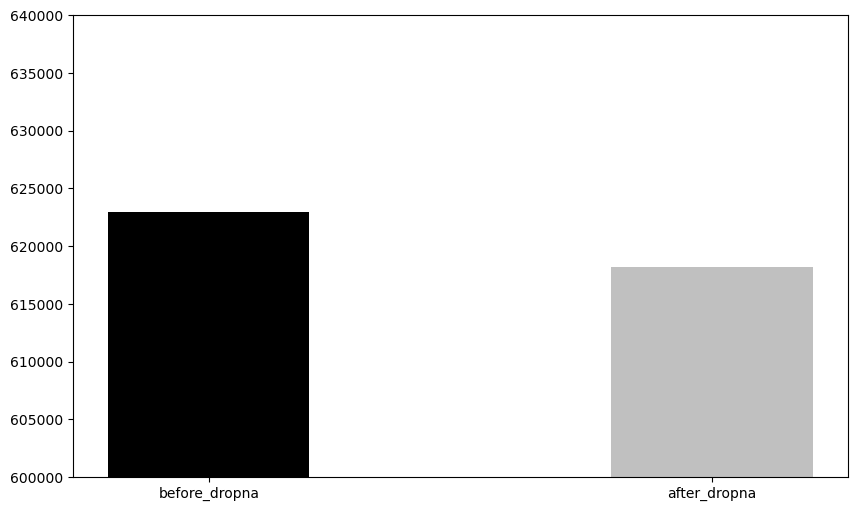

In [10]:
plt.figure(figsize=(10,6))

x = ['before_dropna','after_dropna']
y = [befor_cnt, after_cnt]
colors = ['black','silver']
plt.bar(x, y, width = 0.4, color = colors)

plt.ylim([600000,640000])

plt.show()

2. 파생 변수 생성

In [11]:
fifa_df = fifa_df.withColumn('점핑 헤더',(fifa_df['점프']+fifa_df['헤더'])/2)

In [12]:
fifa_df = fifa_df.drop('점프','헤더')

3. 삼진분류 -> 이진분류

In [13]:
ff = udf(lambda v:0 if v==1 or v==2 else 1)

# result = 1 or 2: No Goal
# result = 3: Goal

In [14]:
fifa_df = fifa_df.withColumn('result',ff(fifa_df['result']))

4. 슈팅 타입별 결과 분포

In [15]:
# 1: normal
# 2: finesse
# 3: header
# 4: lob(로빙)
# 5: flare(플레어슛)
# 6: low(낮은슛)
# 7: volley
# 8: free-kick
# 9: penalty
# 10: knuckle(무회전)

In [16]:
fifa_df.groupBy('type','result').agg(f.count('result').alias('슈팅 수')).orderBy('type','result',ascending=True).show()

22/12/24 22:49:08 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
 Schema: _c0, goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
Expected: _c0 but found: 
CSV file: file:///home/mobile/Desktop/data/final_df.csv


+----+------+-------+
|type|result|슈팅 수|
+----+------+-------+
|   1|     0| 123669|
|   1|     1|  40819|
|   2|     0| 116560|
|   2|     1|  63724|
|   3|     0|  43235|
|   3|     1|  13605|
|   4|     0|   2697|
|   4|     1|   1112|
|   5|     0|      5|
|   6|     0|  93825|
|   6|     1|  76156|
|   7|     0|  10822|
|   7|     1|   7313|
|   8|     0|   7048|
|   8|     1|   1013|
|   9|     0|   1728|
|   9|     1|   5221|
|  10|     0|   7975|
|  10|     1|   1665|
+----+------+-------+



22/12/24 22:49:16 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
 Schema: _c0, goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
Expected: _c0 but found: 
CSV file: file:///home/mobile/Desktop/data/final_df.csv


<AxesSubplot:title={'center':'type ~ shoot cnt'}, xlabel='type'>

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


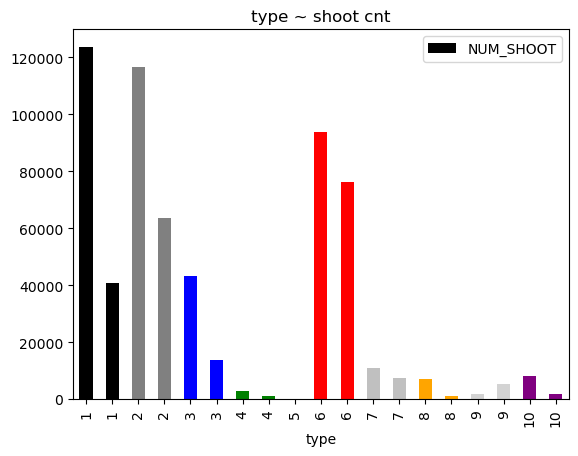

In [17]:
fifa_df.groupBy('type','result').agg(f.count('result').alias('NUM_SHOOT')).orderBy('type','result',ascending=True).toPandas().plot(kind='bar',x='type',y='NUM_SHOOT',title='type ~ shoot cnt',color=['black','black','gray','gray','blue','blue','green','green','black','red','red','silver','silver','orange','orange','lightgrey','lightgrey','purple','purple'])

5. 슈팅 결과와 다른 특성들의 상관관계 분석

In [18]:
fifa_df = fifa_df.withColumn('result',fifa_df['result'].cast(IntegerType()))

In [19]:
type_result = fifa_df.corr('type','result')
GD_result = fifa_df.corr('골 결정력','result')

22/12/24 22:49:25 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
 Schema: _c0, goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
Expected: _c0 but found: 
CSV file: file:///home/mobile/Desktop/data/final_df.csv


22/12/24 22:49:32 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
 Schema: _c0, goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
Expected: _c0 but found: 
CSV file: file:///home/mobile/Desktop/data/final_df.csv


In [20]:
print(type_result, GD_result)

0.12091933102576341 0.08017830084254808


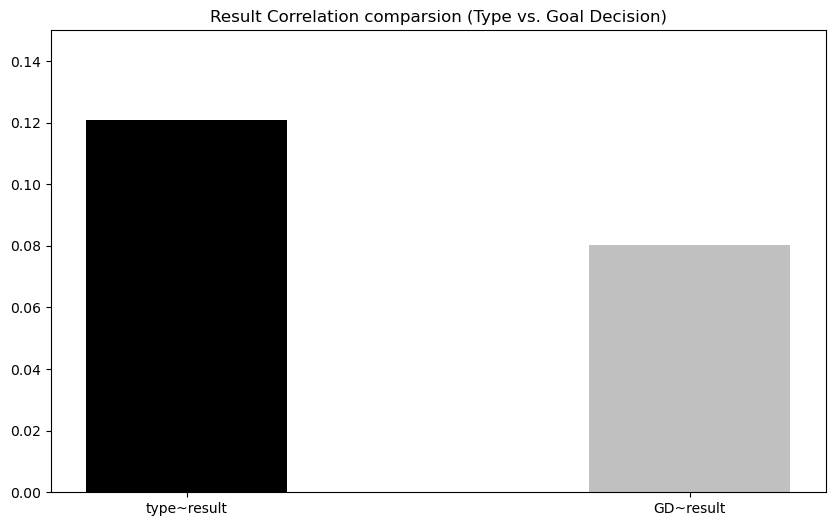

In [21]:
plt.figure(figsize=(10,6))

x = ['type~result','GD~result']
y = [type_result, GD_result]
colors = ['black','silver']
plt.bar(x, y, width = 0.4, color = colors)
plt.title('Result Correlation comparsion (Type vs. Goal Decision)')
plt.ylim([0,0.15])

plt.show()

6. 헤딩 슈팅인 경우, 슈팅 결과에 따른 점핑 헤더의 평균 비교

In [22]:
heading = fifa_df.where('type==3 & result==1').agg(f.avg('점핑 헤더')).toPandas().iloc[0,0]

not_heading = fifa_df.where('type!=3 & result==1').agg(f.avg('점핑 헤더')).toPandas().iloc[0,0]

22/12/24 22:49:39 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
 Schema: _c0, goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
Expected: _c0 but found: 
CSV file: file:///home/mobile/Desktop/data/final_df.csv


22/12/24 22:49:48 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
 Schema: _c0, goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
Expected: _c0 but found: 
CSV file: file:///home/mobile/Desktop/data/final_df.csv


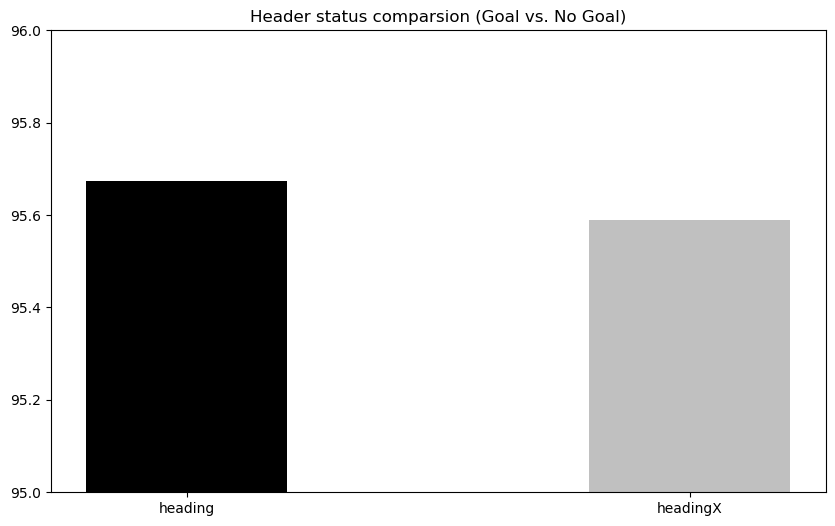

In [23]:
plt.figure(figsize=(10,6))

x = ['heading','headingX']
y = [heading, not_heading]
colors = ['black','silver']
plt.bar(x, y, width = 0.4, color = colors)
plt.title('Header status comparsion (Goal vs. No Goal)')
plt.ylim([95,96])

plt.show()

7. 골 여부에 따른 골 결정력 평균 비교

In [24]:
goal = fifa_df.where('result==1').agg(f.avg('골 결정력')).toPandas().iloc[0,0]

no_goal = fifa_df.where('result==0').agg(f.avg('골 결정력')).toPandas().iloc[0,0]

22/12/24 22:49:56 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
 Schema: _c0, goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
Expected: _c0 but found: 
CSV file: file:///home/mobile/Desktop/data/final_df.csv


22/12/24 22:50:06 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
 Schema: _c0, goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
Expected: _c0 but found: 
CSV file: file:///home/mobile/Desktop/data/final_df.csv


In [25]:
print(goal, no_goal)

103.38133106709459 101.72329499170682


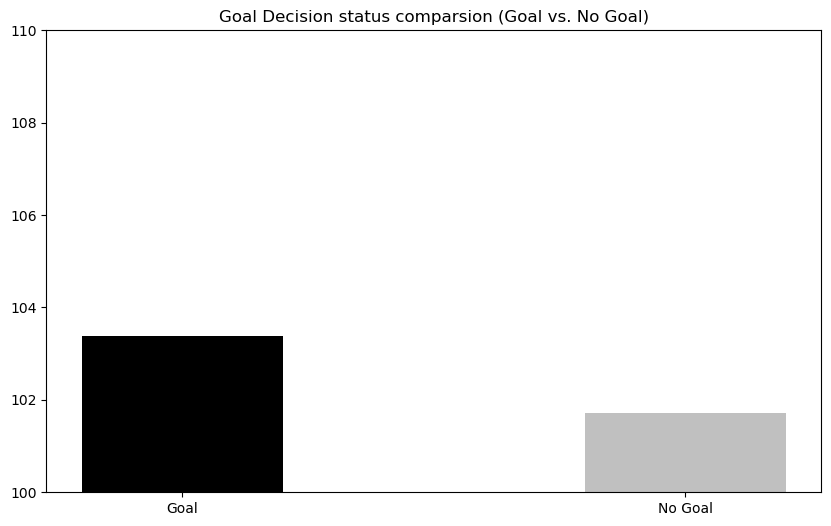

In [26]:
plt.figure(figsize=(10,6))

x = ['Goal','No Goal']
y = [goal, no_goal]
colors = ['black','silver']
plt.bar(x, y, width = 0.4, color = colors)
plt.title('Goal Decision status comparsion (Goal vs. No Goal)')
plt.ylim([100,110])

plt.show()

전체 능력의 합과 슈팅 결과의 상관관계

In [27]:
fifa_df = fifa_df.withColumn('overall',fifa_df['골 결정력']+fifa_df['슛 파워']+fifa_df['중거리 슛']+fifa_df['위치 선정']+fifa_df['발리 슛']+fifa_df['페널티 킥']+fifa_df['프리킥']+fifa_df['커브']+fifa_df['볼 컨트롤']+fifa_df['밸런스']+fifa_df['침착성']+fifa_df['점핑 헤더'])

In [28]:
overall_goal = fifa_df.where('result==1').agg(f.avg('overall')).toPandas().iloc[0,0]

overall_nogoal = fifa_df.where('result==0').agg(f.avg('overall')).toPandas().iloc[0,0]

22/12/24 22:50:16 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
 Schema: _c0, goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
Expected: _c0 but found: 
CSV file: file:///home/mobile/Desktop/data/final_df.csv


22/12/24 22:50:24 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
 Schema: _c0, goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
Expected: _c0 but found: 
CSV file: file:///home/mobile/Desktop/data/final_df.csv


In [53]:
fifa_df.corr('overall','result')

22/12/24 23:21:41 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
 Schema: _c0, goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
Expected: _c0 but found: 
CSV file: file:///home/mobile/Desktop/data/final_df.csv


0.05190960270600731

In [29]:
print(overall_goal, overall_nogoal)

1219.645051939913 1211.757840486402


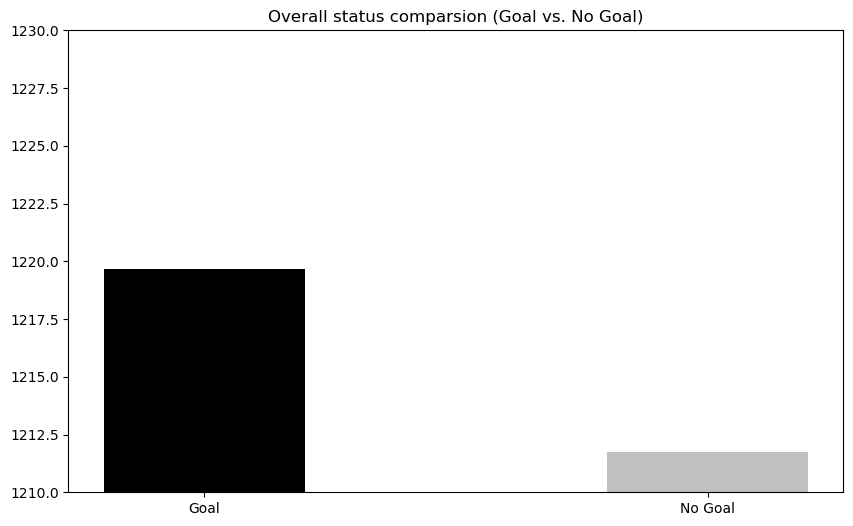

In [30]:
plt.figure(figsize=(10,6))

x = ['Goal','No Goal']
y = [overall_goal, overall_nogoal]
colors = ['black','silver']
plt.bar(x, y, width = 0.4, color = colors)
plt.title('Overall status comparsion (Goal vs. No Goal)')
plt.ylim([1210,1230])

plt.show()

In [31]:
fifa_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- goalTime: integer (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- type: integer (nullable = true)
 |-- spId: integer (nullable = true)
 |-- spGrade: integer (nullable = true)
 |-- spLevel: integer (nullable = true)
 |-- spIdType: boolean (nullable = true)
 |-- assist: boolean (nullable = true)
 |-- assistSpId: integer (nullable = true)
 |-- assistX: double (nullable = true)
 |-- assistY: double (nullable = true)
 |-- hitPost: boolean (nullable = true)
 |-- inPenalty: boolean (nullable = true)
 |-- result: integer (nullable = true)
 |-- id: double (nullable = true)
 |-- name: string (nullable = true)
 |-- season: string (nullable = true)
 |-- 포지션: string (nullable = true)
 |-- 골 결정력: double (nullable = true)
 |-- 슛 파워: double (nullable = true)
 |-- 중거리 슛: double (nullable = true)
 |-- 위치 선정: double (nullable = true)
 |-- 발리 슛: double (nullable = true)
 |-- 페널티 킥: double (nullable = true)
 |-- 프리킥: dou

슈팅 타입과 전체 능력치를 통한 슈팅 결과 분류 모델 생성

In [45]:
c = ['type','overall']

fea = VectorAssembler(inputCols=c, outputCol ='features')


v_df = fea.transform(fifa_df)

v_df.show()

22/12/24 23:12:38 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
 Schema: _c0, goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
Expected: _c0 but found: 
CSV file: file:///home/mobile/Desktop/data/final_df.csv
+---+--------+------------------+-------------------+----+---------+-------+-------+--------+------+----------+------------------+-------------------+-------+---------+------+------------+-----------------+--------------------+------+---------+-------+---------+---------+-------+---------+------+-----+---------+------+------+---------+-------+------------+
|_c0|goalTime|

In [46]:
train_df, test_df = v_df.randomSplit([0.7,0.3])

In [47]:
lr = LogisticRegression(featuresCol='features',labelCol='result')

lrModel = lr.fit(train_df)

22/12/24 23:12:43 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
 Schema: _c0, goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
Expected: _c0 but found: 
CSV file: file:///home/mobile/Desktop/data/final_df.csv


22/12/24 23:13:02 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
 Schema: _c0, goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
Expected: _c0 but found: 
CSV file: file:///home/mobile/Desktop/data/final_df.csv


In [48]:
lr_predict = lrModel.transform(test_df)

lr_predict.show()

22/12/24 23:13:13 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
 Schema: _c0, goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
Expected: _c0 but found: 
CSV file: file:///home/mobile/Desktop/data/final_df.csv


+---+--------+------------------+-------------------+----+---------+-------+-------+--------+------+----------+------------------+------------------+-------+---------+------+------------+-----------------+--------------------+------+---------+-------+---------+---------+-------+---------+------+-----+---------+------+------+---------+-------+-------------+--------------------+--------------------+----------+
|_c0|goalTime|                 x|                  y|type|     spId|spGrade|spLevel|spIdType|assist|assistSpId|           assistX|           assistY|hitPost|inPenalty|result|          id|             name|              season|포지션|골 결정력|슛 파워|중거리 슛|위치 선정|발리 슛|페널티 킥|프리킥| 커브|볼 컨트롤|밸런스|침착성|점핑 헤더|overall|     features|       rawPrediction|         probability|prediction|
+---+--------+------------------+-------------------+----+---------+-------+-------+--------+------+----------+------------------+------------------+-------+---------+------+------------+-----------------+---------------

In [49]:
lr_predict.select( 'prediction','result',
        'features').show(lr_predict.count())

22/12/24 23:13:21 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
 Schema: _c0, goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
Expected: _c0 but found: 
CSV file: file:///home/mobile/Desktop/data/final_df.csv


22/12/24 23:13:30 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
 Schema: _c0, goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
Expected: _c0 but found: 
CSV file: file:///home/mobile/Desktop/data/final_df.csv


IOPub data rate exceeded.                                                       
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [50]:
print("기울기(w)",lrModel.coefficients )
print("절편(b)", lrModel.intercept )

기울기(w) [0.10566909415165864,0.0015078453497132634]
절편(b) -2.857236533204976


In [51]:
evaluator = MulticlassClassificationEvaluator(
 labelCol="result",  predictionCol="prediction",
    metricName="accuracy")
print(evaluator.evaluate(lr_predict))

22/12/24 23:13:47 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
 Schema: _c0, goalTime, x, y, type, spId, spGrade, spLevel, spIdType, assist, assistSpId, assistX, assistY, hitPost, inPenalty, result, id, name, season, 포지션, 골 결정력, 슛 파워, 중거리 슛, 위치 선정, 발리 슛, 페널티 킥, 프리킥, 커브, 볼 컨트롤, 밸런스, 헤더, 점프, 침착성
Expected: _c0 but found: 
CSV file: file:///home/mobile/Desktop/data/final_df.csv


0.6557206473803953
